In [1]:
###################################################################################################
#
# Copyright (C) 2024 Analog Devices, Inc. All Rights Reserved.
# This software is proprietary and confidential to Analog Devices, Inc. and its licensors.
#
###################################################################################################
"""
For more details about the dataset, data loader, model and training,
please see the following documentation:
https://github.com/analogdevicesinc/MaximAI_Documentation/blob/master/Guides/MAX78000%20Motor%20Monitoring%20Case%20Study%20with%20SampleMotorDataLimerick%20Dataset.pdf
"""
import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))

from datasets import samplemotordatalimerick

ai85net_autoencoder = __import__("ai85net-autoencoder")

import parse_qat_yaml
import ai8x

from torch.utils import data

from distiller import apputils

import seaborn as sns

from statistics import mean

%matplotlib inline

In [2]:
from utils import autoencoder_eval_utils as utilsV5


In [3]:
directory = os.getcwd()
training_dir = os.path.abspath(os.path.join(directory, os.pardir))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = os.path.join(training_dir, 'data')
simulate = False

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=simulate)

ai8x.set_device(device=85, simulate=simulate, round_avg=True)

Configuring device: MAX78000, simulate=False.


In [5]:
# Generate Dataset For Evaluation
train_set, test_set = samplemotordatalimerick.samplemotordatalimerick_get_datasets_for_eval_with_anomaly_label((data_path, args), load_train=True, load_test=True)


SampleMotorDataLimerick dataset already downloaded...

SampleMotorDataLimerick_dataframe.pkl file already exists


Pickle files are already generated ...

Train dataset length: 230


SampleMotorDataLimerick dataset already downloaded...

SampleMotorDataLimerick_dataframe.pkl file already exists


Pickle files are already generated ...

Test dataset length: 3540



In [6]:
batch_size = 32
train_dataloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

### 1. Load Trained AE

In [7]:
model = ai85net_autoencoder.ai85autoencoder()
_ = utilsV5.calc_model_size(model)

Batchnorm setting in model =  True

Number of Model Weights: 136640
Number of Model Bias: 544



In [8]:
# Change this checkpoint file path with your own trained one
checkpoint_path = os.path.abspath(os.path.join(training_dir, os.pardir, 'ai8x-synthesis', 'trained', 'ai85-autoencoder-samplemotordatalimerick-qat.pth.tar'))

In [9]:
qat_yaml_file_used_in_training = os.path.join(training_dir, 'policies', 'qat_policy_autoencoder.yaml')

qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

ai8x.set_device(85, simulate, False)

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

model = apputils.load_lean_checkpoint(model, checkpoint_path, model_device=device)
ai8x.update_model(model)

model = model.to(device)

{'start_epoch': 200, 'weight_bits': 8, 'shift_quantile': 0.995}
Configuring device: MAX78000, simulate=False.


Visualizing whether trained model has good separation the latent space

In [10]:
train_base_tuple = utilsV5.extract_reconstructions_losses(model, train_dataloader, device)
train_base_reconstructions, train_base_losses, train_base_inputs, train_base_labels = \
    train_base_tuple
    
    
print(len(train_base_losses))

230


In [11]:
test_base_tuple = utilsV5.extract_reconstructions_losses(model, test_dataloader, device)
test_base_reconstructions, test_base_losses, test_base_inputs, test_base_labels = \
    test_base_tuple
    
print(len(test_base_losses))

3540


In [12]:
mean(test_base_losses)

0.08606820548770566

In [13]:
normal_test_sample_idxs = [test_item_idx for test_item_idx, test_item in enumerate(test_set) if test_item[1] == 0]
normal_test_samples = torch.utils.data.Subset(test_set, normal_test_sample_idxs)
normal_test_samples_loader = torch.utils.data.DataLoader(normal_test_samples, batch_size=batch_size)
print(len(normal_test_sample_idxs))

60


In [14]:
normal_base_output = utilsV5.extract_reconstructions_losses(model, normal_test_samples_loader, device)
    
test_base_normal_reconstructions, test_base_normal_losses, \
test_base_normal_inputs, test_base_normal_labels = normal_base_output

print(test_base_normal_losses)

[0.027154843012491863, 0.01931905746459961, 0.022384484608968098, 0.027895212173461914, 0.02215234438578288, 0.02309735616048177, 0.01860976219177246, 0.0230864683787028, 0.022903998692830402, 0.02098989486694336, 0.017391522725423176, 0.02986884117126465, 0.025111277898152668, 0.026648998260498047, 0.0289913813273112, 0.028342485427856445, 0.02594900131225586, 0.023530244827270508, 0.02023140589396159, 0.023876508076985676, 0.025062402089436848, 0.03147419293721517, 0.026927073796590168, 0.02293237050374349, 0.02016894022623698, 0.03138017654418945, 0.029456456502278645, 0.02879174550374349, 0.03609673182169596, 0.042246739069620766, 0.011744022369384766, 0.014452854792277018, 0.01569652557373047, 0.0213166077931722, 0.024822314580281574, 0.02770860989888509, 0.0341958204905192, 0.02867404619852702, 0.026907602945963543, 0.025069236755371094, 0.018611669540405273, 0.021029233932495117, 0.010935386021931967, 0.012288649876912435, 0.01129762331644694, 0.011835495630900065, 0.01110553741

In [15]:
anormal_test_sample_idxs = [test_item_idx for test_item_idx, test_item in enumerate(test_set) if test_item[1] == 1]
print(len(anormal_test_sample_idxs))

anormal_test_samples = torch.utils.data.Subset(test_set, anormal_test_sample_idxs)
anormal_test_samples_loader = torch.utils.data.DataLoader(anormal_test_samples, batch_size=batch_size)

3480


In [16]:
anormal_base_output = utilsV5.extract_reconstructions_losses(model, anormal_test_samples_loader, device)
    
test_base_anormal_reconstructions, test_base_anormal_losses, \
test_base_anormal_inputs, test_base_anormal_labels = anormal_base_output

### **2. Determine Reconst. Err. Threshold:** Using 100% percentile on base model

In [17]:
percentiles = [60, 65, 70, 75, 80, 85, 90, 95, 99, 100]
thresholds = np.percentile(train_base_losses, percentiles)

for idx, threshold in enumerate(thresholds):
    print(f'{percentiles[idx]}% percentile threshold: {threshold:.4f}')

60% percentile threshold: 0.0167
65% percentile threshold: 0.0177
70% percentile threshold: 0.0190
75% percentile threshold: 0.0201
80% percentile threshold: 0.0209
85% percentile threshold: 0.0223
90% percentile threshold: 0.0235
95% percentile threshold: 0.0250
99% percentile threshold: 0.0271
100% percentile threshold: 0.0357


In [18]:
from statistics import mean
mean(train_base_losses)

0.01594951049141262

In [19]:
mean(test_base_normal_losses)

0.022111524475945367

In [20]:
len(test_base_normal_losses)

60

In [21]:
# Calculating performance metrics with respect to changing thresholds
F1s, BalancedAccuracies, FPRs, Recalls = utilsV5.sweep_performance_metrics(thresholds, train_base_tuple, test_base_tuple)

F1:  0.9934, BalancedAccuracy:  0.6167, FPRate:  0.7667, Precision:  0.9870, TPRate (Recall):  1.0000, Accuracy:  0.9870, TRAIN-SET Accuracy:  0.6000
F1:  0.9939, BalancedAccuracy:  0.6417, FPRate:  0.7167, Precision:  0.9878, TPRate (Recall):  1.0000, Accuracy:  0.9879, TRAIN-SET Accuracy:  0.6478
F1:  0.9943, BalancedAccuracy:  0.6667, FPRate:  0.6667, Precision:  0.9886, TPRate (Recall):  1.0000, Accuracy:  0.9887, TRAIN-SET Accuracy:  0.7000
F1:  0.9944, BalancedAccuracy:  0.6750, FPRate:  0.6500, Precision:  0.9889, TPRate (Recall):  1.0000, Accuracy:  0.9890, TRAIN-SET Accuracy:  0.7478
F1:  0.9947, BalancedAccuracy:  0.6917, FPRate:  0.6167, Precision:  0.9895, TPRate (Recall):  1.0000, Accuracy:  0.9895, TRAIN-SET Accuracy:  0.8000
F1:  0.9951, BalancedAccuracy:  0.7330, FPRate:  0.5333, Precision:  0.9909, TPRate (Recall):  0.9994, Accuracy:  0.9904, TRAIN-SET Accuracy:  0.8478
F1:  0.9960, BalancedAccuracy:  0.7912, FPRate:  0.4167, Precision:  0.9929, TPRate (Recall):  0.999

Text(0.5, 0, 'Reconstruction Loss (RL)')

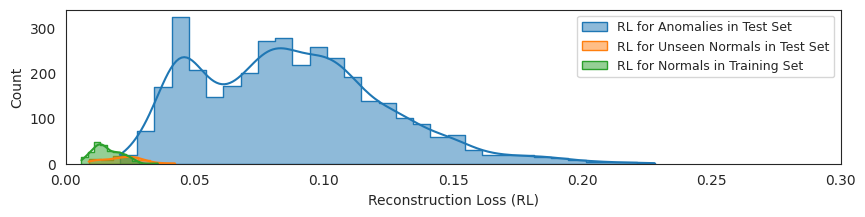

In [22]:
plt.figure(figsize=(10, 2))

plt.xlim([0, 0.3])

sns.histplot(test_base_anormal_losses, element="step", label='RL for Anomalies in Test Set', kde=True)
sns.histplot(test_base_normal_losses, element="step", label='RL for Unseen Normals in Test Set', kde=True)
sns.histplot(train_base_losses, element="step", label='RL for Normals in Training Set', kde=True)

plt.legend(prop={'size': 9}, loc='best')
plt.xlabel('Reconstruction Loss (RL)')

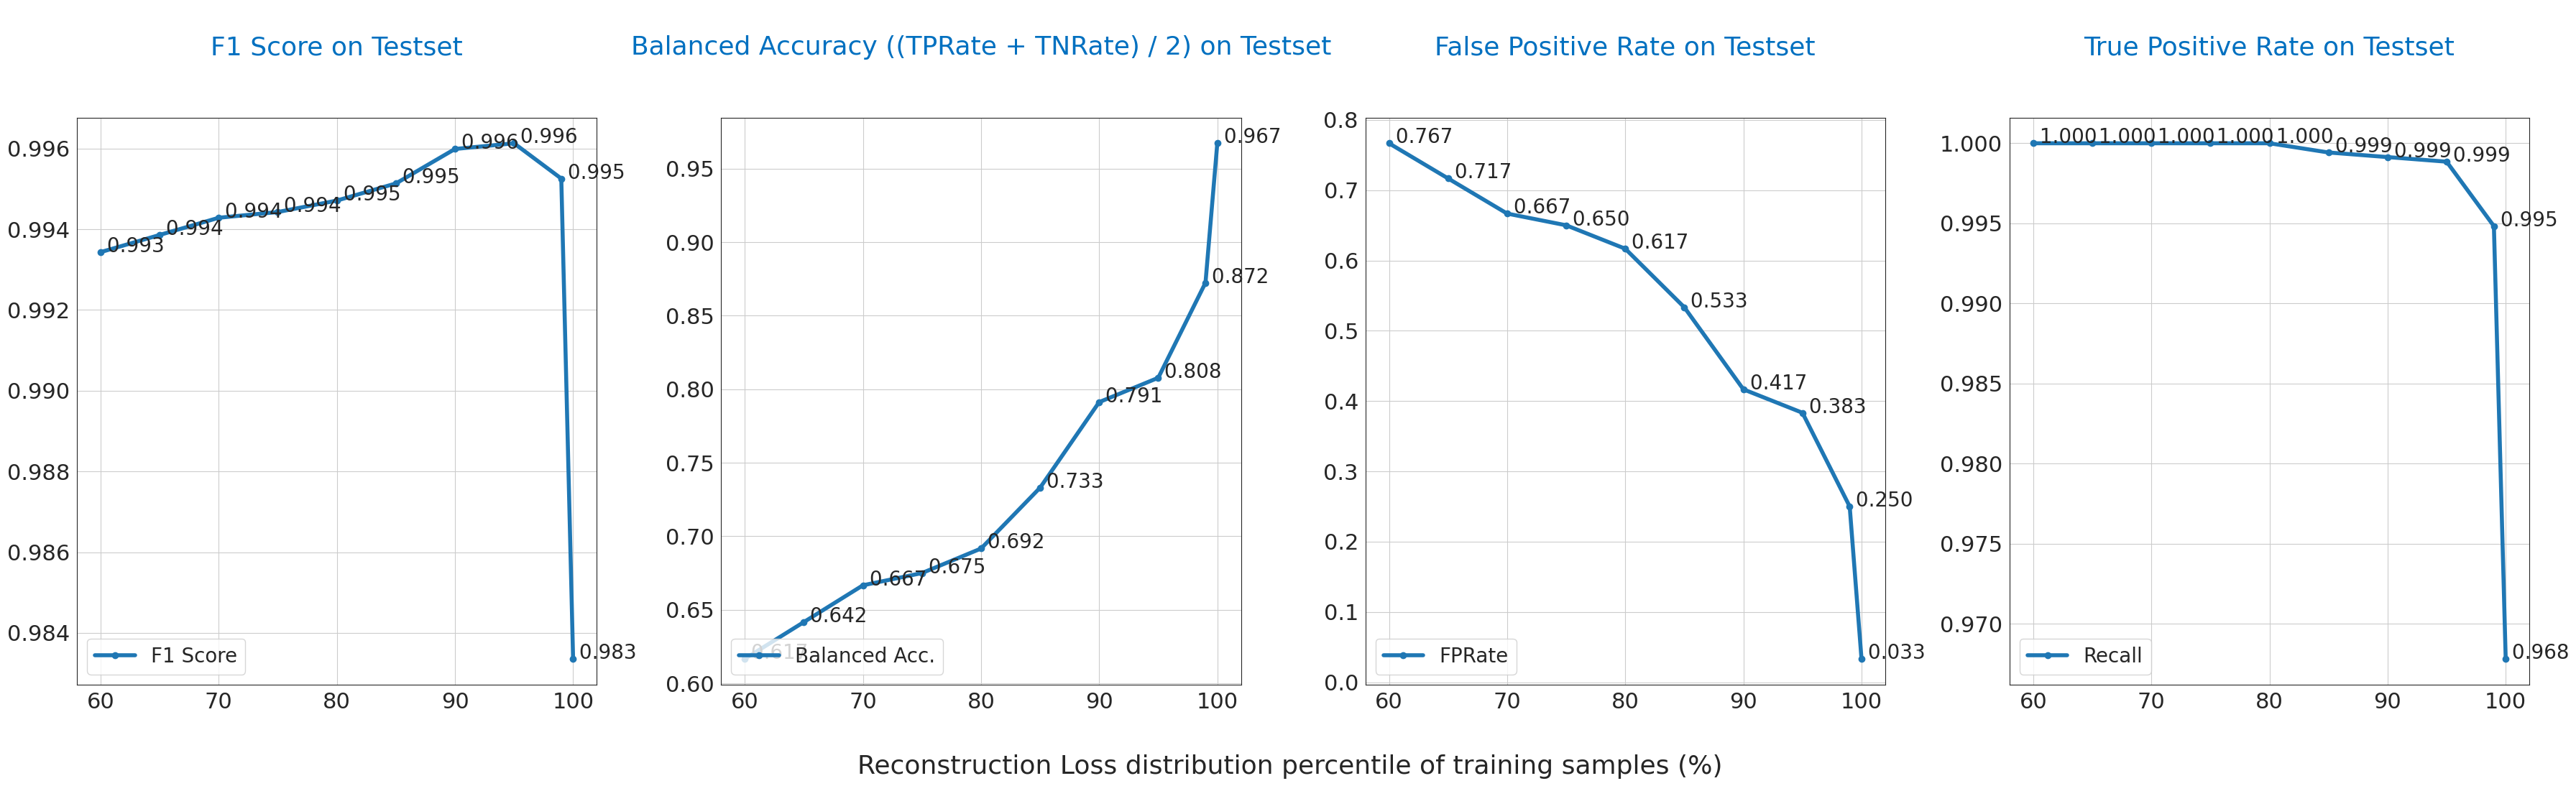

In [23]:
utilsV5.plot_all_metrics(F1s=F1s, BalancedAccuracies=BalancedAccuracies, FPRs=FPRs, Recalls=Recalls, percentiles=percentiles)